In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
import joblib
import os

# Laden der bereinigten CSV-Datei
df = pd.read_csv("df.csv")

# Schritt 1: Sentimentanalyse hinzufügen
print("Starte Sentimentanalyse...")

# Verwende Hugging Face's Transformers Pipeline für die Sentimentanalyse
sentiment_analyzer = pipeline("sentiment-analysis")
# Sicherstellen, dass alle Einträge Strings sind
df['Filtered_Content'] = df['Filtered_Content'].fillna("").astype(str)

# Funktion zur Berechnung des Sentiments
def compute_sentiment(text):
    if isinstance(text, str) and len(text) > 0:
        result = sentiment_analyzer(text[:512])[0]  # Text auf 512 Zeichen begrenzen
        return result['label'], result['score']
    else:
        return "NEUTRAL", 0.0  # Standardwerte für ungültige Einträge

# Berechnung von Sentiment und Scores
df['Sentiment'], df['Sentiment_Score'] = zip(*df['Filtered_Content'].apply(compute_sentiment))


# Speichern der Ergebnisse in einer Datei
df.to_csv("sentiment_results.csv", index=False)
print("Sentimentanalyse abgeschlossen und gespeichert.")

# Schritt 2: TF-IDF Vektorisierung
print("Starte TF-IDF Vektorisierung...")
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Begrenze auf 1000 Features für bessere Performance
X_tfidf = tfidf_vectorizer.fit_transform(df['Filtered_Content'])
y = df['NegoOutcomeLabel']

# Speichern des TF-IDF-Vektorizers
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

# Schritt 3: Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Schritt 4: Training eines komplexeren Modells
print("Starte Training eines RandomForest-Klassifikators...")
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train)

# Vorhersagen
y_pred = rf_classifier.predict(X_test)

# Evaluation
print("Modellergebnisse:")
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Speichern des Modells
joblib.dump(rf_classifier, "random_forest_model.pkl")

# Schritt 5: Speichern der Ergebnisse
results = {
    "accuracy": accuracy_score(y_test, y_pred),
    "classification_report": classification_report(y_test, y_pred, output_dict=True)
}
results_df = pd.DataFrame(results)
results_df.to_csv("model_results.csv", index=False)

print("Alle Ergebnisse gespeichert.")

# Dokumentation der Top-TFIDF-Features
feature_importances = rf_classifier.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()
important_features = sorted(zip(feature_importances, feature_names), reverse=True)[:50]
important_features_df = pd.DataFrame(important_features, columns=["Importance", "Feature"])
important_features_df.to_csv("top_tfidf_features.csv", index=False)

print("Top TF-IDF Features gespeichert.")

# Schritt 6: Korrelation von Sentiment mit Erfolg
print("Berechne Korrelation zwischen Sentiment und Erfolg...")
sentiment_success = df.groupby(['Sentiment', 'NegoOutcomeLabel']).size().unstack(fill_value=0)
sentiment_success.to_csv("sentiment_success_correlation.csv")

print("Korrelationsergebnisse gespeichert.")


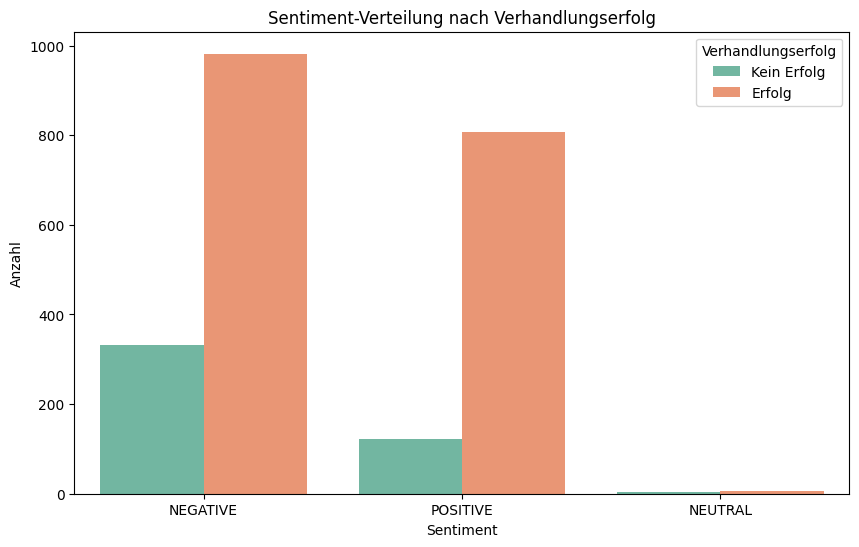

C:\Users\Alex\AppData\Local\Temp\ipykernel_3812\2659256721.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="NegoOutcomeLabel", y="Sentiment_Score", palette="coolwarm")


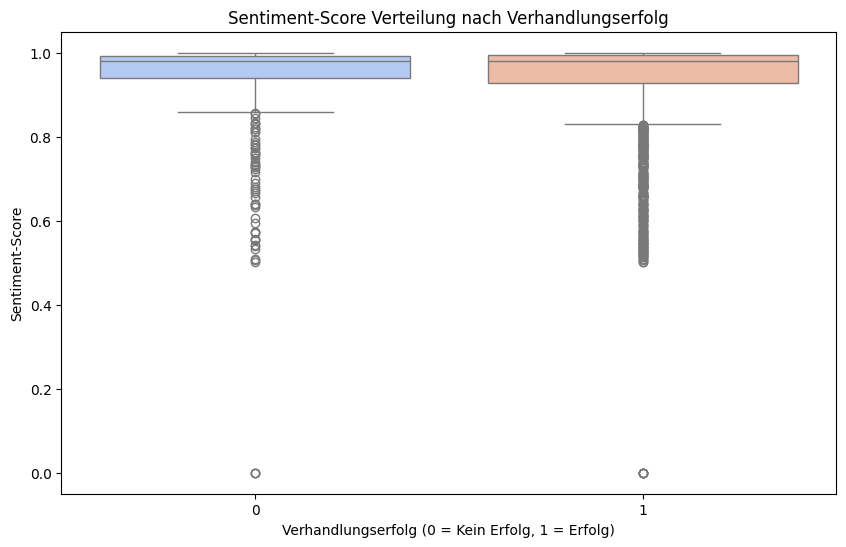

C:\Users\Alex\AppData\Local\Temp\ipykernel_3812\2659256721.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tfidf_features, y="Feature", x="Importance", palette="viridis")


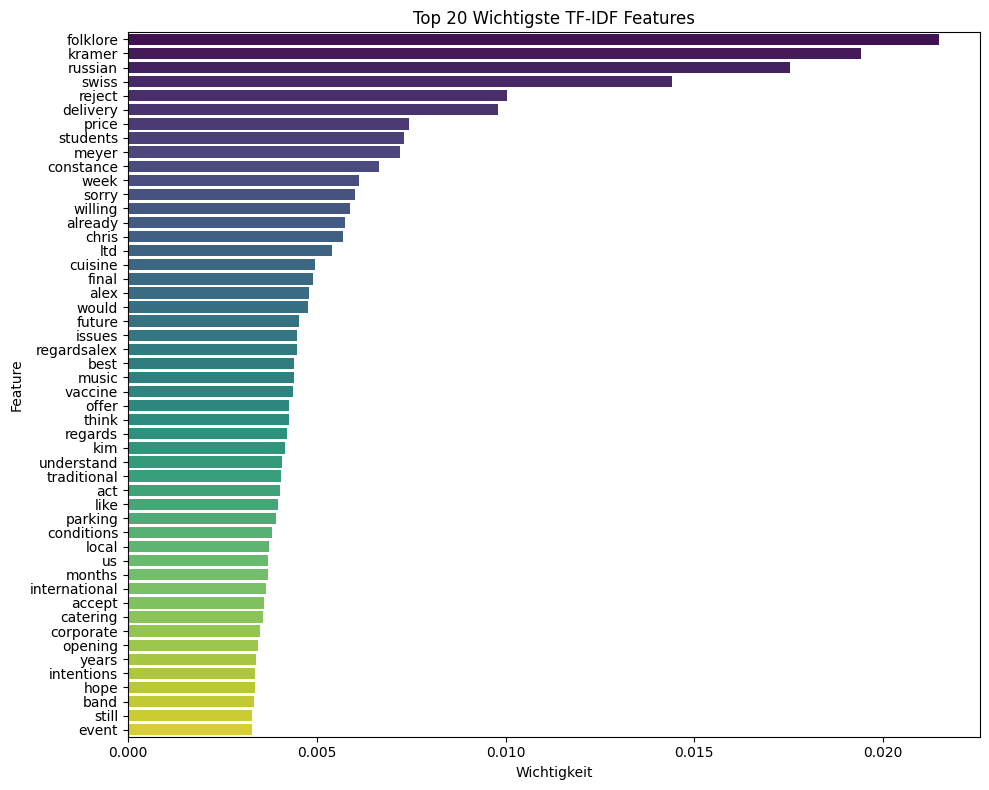

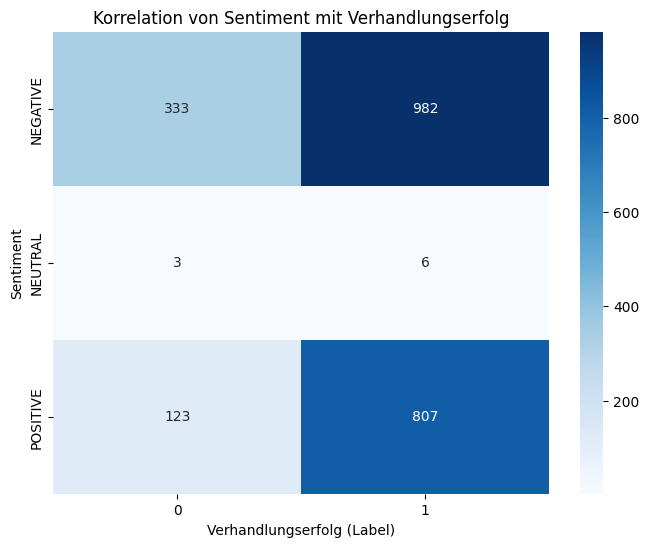

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lade die gespeicherten Ergebnisse
df = pd.read_csv("sentiment/sentiment_results.csv")
correlation_data = pd.read_csv("sentiment/sentiment_success_correlation.csv")

# Plot 1: Sentiment Verteilung
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Sentiment", hue="NegoOutcomeLabel", palette="Set2")
plt.title("Sentiment-Verteilung nach Verhandlungserfolg")
plt.xlabel("Sentiment")
plt.ylabel("Anzahl")
plt.legend(title="Verhandlungserfolg", labels=["Kein Erfolg", "Erfolg"])
plt.savefig("sentiment_verteilung_nach_erfolg.png")
plt.show()

# Plot 2: Korrelation von Sentiment-Score mit Erfolg
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="NegoOutcomeLabel", y="Sentiment_Score", palette="coolwarm")
plt.title("Sentiment-Score Verteilung nach Verhandlungserfolg")
plt.xlabel("Verhandlungserfolg (0 = Kein Erfolg, 1 = Erfolg)")
plt.ylabel("Sentiment-Score")
plt.savefig("sentiment_score_nach_erfolg.png")
plt.show()

# Plot 3: Top-TFIDF Features und ihre Wichtigkeiten
tfidf_features = pd.read_csv("sentiment/top_tfidf_features.csv")

plt.figure(figsize=(10, 8))
sns.barplot(data=tfidf_features, y="Feature", x="Importance", palette="viridis")
plt.title("Top 20 Wichtigste TF-IDF Features")
plt.xlabel("Wichtigkeit")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("top_tfidf_features.png")
plt.show()

# Plot 4: Korrelationstabellen als Heatmap darstellen (Sentiment vs. Erfolg)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data.set_index("Sentiment"), annot=True, cmap="Blues", fmt="d")
plt.title("Korrelation von Sentiment mit Verhandlungserfolg")
plt.xlabel("Verhandlungserfolg (Label)")
plt.ylabel("Sentiment")
plt.savefig("sentiment_korrelation_heatmap.png")
plt.show()

# Ergebnisse als Übersicht speichern
overview_results = pd.DataFrame({
    "Model Accuracy": [0.8159],
    "Macro Avg Recall": [0.61],
    "Weighted Avg F1-Score": [0.77]
})
overview_results.to_csv("modell_uebersicht.csv", index=False)
